In the following implementation, "paper1" refers to the HOSVD_w algorithm in https://arxiv.org/pdf/2003.08537.pdf, and "paper2" refers to the SO-HOSVD algorithm in https://arxiv.org/pdf/1711.04934.pdf. 

It takes about 30 minutes to run the cells before the least squares part at the end.

In [1]:
import numpy as np
import tensorly as tl
import time
import os
from tensorly.decomposition import tucker, parafac, non_negative_tucker
from tensorly import tucker_to_tensor
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd
from itertools import combinations
import multiprocessing as mp

#import apgpy
from scipy.sparse.linalg import svds
import mkl
mkl.set_num_threads(1)

from util import std_logistic_function, get_square_set, square_unfolding, \
normalized_error, tenips_general, tenips_general_paper1, generate_orthogonal_mats, \
unfolding_based_ips_tensor_completion

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

generate data tensor

In [2]:
# Low rank + noise
r = [5, 5, 5, 5]
I = 100
N = len(r)
noise_para = 0.1 # noise parameter

np.random.seed(1)
# real_core = tl.tensor(np.random.uniform(-1, 1, r))
real_core = 200 * tl.tensor(np.random.randn(*r))
factor_matrices = [generate_orthogonal_mats((I, r[0])) for i in range(N)]
real_B = tucker_to_tensor((real_core, factor_matrices))
fro_norm = np.linalg.norm(real_B)
noise_coeff = noise_para * fro_norm / I ** (len(r)*1./2)
noise_ten = tl.tensor(np.random.normal(0, 1, [I]*N))

B = real_B + noise_coeff*noise_ten

histogram of entry values in the data tensor

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000., 70000000., 80000000.]),
 <a list of 9 Text yticklabel objects>)

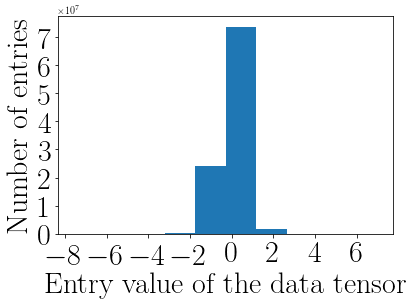

In [3]:
fontsize = 30
plt.hist(B.flatten())
plt.ylabel("Number of entries", fontsize=fontsize)
plt.xlabel("Entry value of the data tensor", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

In [4]:
def uniform_sampling(ratio, tensor):
    """
    Uniformly sample the given tensor with given ratio. Output the sampled tensor with missing entries masked
    by 0, and the numpy array of indices of sampled entries.
    """
    sampled_tensor = tensor.copy()
    select_indices = np.random.choice([True,False],tensor.shape,p=[ratio,1-ratio])
    sampled_tensor[np.invert(select_indices)] = 0.0
    return sampled_tensor, select_indices

In [5]:
ratio_lst = list(np.arange(0.1, 0.75, 0.05)) # the list of subsampling ratios to iterate over

TenIPS

In [6]:
def normalized_error(a, b):
    return np.linalg.norm(a - b) / np.linalg.norm(a)

In [7]:
def get_tenips_error(ratio, B, r):
    sampled_Bs, select_idxs = uniform_sampling(ratio, B)
    prop_B = np.ones(sampled_Bs.shape) * ratio
    mask_B = np.ones(sampled_Bs.shape)
    mask_B[np.invert(select_idxs)] = 0.0
    print("start ratio: {}".format(ratio))
    B_res = tenips_general(sampled_Bs, prop_B,r)
    return normalized_error(B, B_res)

def get_tenips_error_paper1(ratio, B, r):
    sampled_Bs, select_idxs = uniform_sampling(ratio, B)
    prop_B = np.ones(sampled_Bs.shape) * ratio
    mask_B = np.ones(sampled_Bs.shape)
    mask_B[np.invert(select_idxs)] = 0.0
    print("start ratio: {}".format(ratio))
    B_res = tenips_general_paper1(sampled_Bs, prop_B, r)
    return normalized_error(B, B_res)

In [8]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_tenips_error, args=[ratio, B, r]) for ratio in ratio_lst]
p.close()
p.join()

norm_errors_general = [item.get() for item in results]

start ratio: 0.1
start ratio: 0.15000000000000002
start ratio: 0.20000000000000004
start ratio: 0.25000000000000006
start ratio: 0.30000000000000004
start ratio: 0.3500000000000001
start ratio: 0.40000000000000013
start ratio: 0.45000000000000007
start ratio: 0.5000000000000001
start ratio: 0.5500000000000002
start ratio: 0.6000000000000002
start ratio: 0.6500000000000001
start ratio: 0.7000000000000002


In [9]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_tenips_error_paper1, args=[ratio, B, r]) for ratio in ratio_lst]
p.close()
p.join()

norm_errors_general_paper1 = [item.get() for item in results]

start ratio: 0.1
start ratio: 0.15000000000000002
start ratio: 0.20000000000000004
start ratio: 0.25000000000000006
start ratio: 0.30000000000000004
start ratio: 0.3500000000000001
start ratio: 0.40000000000000013
start ratio: 0.45000000000000007
start ratio: 0.5000000000000001
start ratio: 0.5500000000000002
start ratio: 0.6000000000000002
start ratio: 0.6500000000000001
start ratio: 0.7000000000000002


unfoldings

In [10]:
def get_unfolding_error(ratio, B, r):
    x_mat_0 = tl.unfold(B,0)
    x_mat_sq = square_unfolding(B)
    sampled_Bs,select_idxs = uniform_sampling(ratio, B)
    prop_B = np.ones(sampled_Bs.shape) * ratio
    mask_B = np.ones(sampled_Bs.shape)
    mask_B[np.invert(select_idxs)] = 0.0
    print("start ratio: {}".format(ratio))
    x_res_square = unfolding_based_ips_tensor_completion(sampled_Bs, prop_B, r, unfolding='square')
    x_res_unfolding0 = unfolding_based_ips_tensor_completion(sampled_Bs, prop_B, r, unfolding='0')
    return normalized_error(x_mat_sq, x_res_square), normalized_error(x_mat_0, x_res_unfolding0)

In [11]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_unfolding_error, args=[ratio, B, r]) for ratio in ratio_lst]
p.close()
p.join()

norm_errors_mat_square = [item.get()[0] for item in results]
norm_errors_mat_unfolding0 = [item.get()[1] for item in results]

start ratio: 0.1
rank is 25
start ratio: 0.15000000000000002
rank is 25
start ratio: 0.20000000000000004
rank is 25
start ratio: 0.25000000000000006
rank is 25
start ratio: 0.30000000000000004
start ratio: 0.3500000000000001
rank is 25
rank is 25
start ratio: 0.40000000000000013
rank is 25
start ratio: 0.45000000000000007
rank is 25
start ratio: 0.5000000000000001
rank is 25rank is 5

start ratio: 0.5500000000000002
rank is 25
start ratio: 0.6000000000000002
rank is 25
rank is 5
rank is 5
start ratio: 0.6500000000000001
rank is 5
rank is 25
rank is 5
start ratio: 0.7000000000000002
rank is 25
rank is 5
rank is 5
rank is 5
rank is 5
rank is 5
rank is 5
rank is 5
rank is 5


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


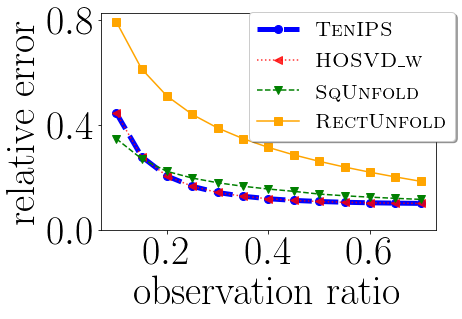

In [12]:
fontsize = 50
markersize = 8
colors = ['blue', 'green', 'orange','red','yellow']

plt.plot(ratio_lst, norm_errors_general, 'bo', linestyle='dashed', markersize=markersize, color=colors[0], linewidth=5, label=r"\textsc{TenIPS}")
plt.plot(ratio_lst, norm_errors_general_paper1, 'bo', marker='<', linestyle='dotted', alpha=0.8, markersize=markersize, color=colors[3], label=r"\textsc{HOSVD\_w}")
plt.plot(ratio_lst, norm_errors_mat_square, 'bo', marker='v', linestyle='--', markersize=markersize, color=colors[1], label=r"\textsc{SqUnfold}")
plt.plot(ratio_lst, norm_errors_mat_unfolding0, 'bo', marker='s', linestyle='-', markersize=markersize, color=colors[2], label=r"\textsc{RectUnfold}")


plt.ylabel("relative error", fontsize=fontsize-10)
plt.xlabel("observation ratio", fontsize=fontsize-10)
xtick_pos = [0.2, 0.4, 0.6]
ytick_pos = [0, 0.4, 0.8]
plt.xticks(xtick_pos, fontsize=fontsize-10)
plt.yticks(ytick_pos, fontsize=fontsize-10)

plt.legend(loc='upper center', bbox_to_anchor=(.75, 1.05), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-29)


fig_path = 'figs'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
plt.savefig(os.path.join(fig_path, "MCAR_relative_error_on_ratio.pdf"), bbox_inches='tight')

In [13]:
# TenIPS, propensity-reweighted, different ratio, different random seeds
norm_errors_general_rank = []
norm_errors_general_paper1_rank = []
rank_list = [1,2,3,4,5,6,7,8,9]
for rank in rank_list:
    ratio = 0.4
    r = [rank,rank,rank,rank]
    sampled_Xs,select_idxs = uniform_sampling(ratio, B)
    prop_X = np.ones(sampled_Xs.shape)*ratio
    mask_X = np.ones(sampled_Xs.shape)
    mask_X[np.invert(select_idxs)] = 0.0
    print("start rank: {}".format(rank))

    X_res = tenips_general(sampled_Xs,prop_X,r)
    X_res_paper1 = tenips_general_paper1(sampled_Xs,prop_X,r)
    norm_errors_general_rank.append(normalized_error(B, X_res))
    norm_errors_general_paper1_rank.append(normalized_error(B, X_res_paper1))

start rank: 1
start rank: 2
start rank: 3
start rank: 4
start rank: 5
start rank: 6
start rank: 7
start rank: 8
start rank: 9


In [14]:
# Matrix Completion, propensity reweighted, different ratio
norm_errors_mat_square_rank = []
norm_errors_mat_unfolding0_rank = []

x_mat_0 = tl.unfold(B, 0)
x_mat_sq = square_unfolding(B)
for rank in rank_list:
    ratio = 0.4
    r = [rank,rank,rank,rank]
    sampled_Xs,select_idxs = uniform_sampling(ratio, B)
    prop_X = np.ones(sampled_Xs.shape)*ratio
    mask_X = np.ones(sampled_Xs.shape)
    mask_X[np.invert(select_idxs)] = 0.0
    print("start rank: {}".format(rank))
    prop_X_sq = square_unfolding(prop_X)
    prop_X_u0 = tl.unfold(prop_X, 0)
    x_res_square = unfolding_based_ips_tensor_completion(sampled_Xs, prop_X, r, unfolding='square')
    x_res_unfolding0 = unfolding_based_ips_tensor_completion(sampled_Xs, prop_X, r, unfolding='0')
    norm_errors_mat_square_rank.append(normalized_error(x_mat_sq, x_res_square))
    norm_errors_mat_unfolding0_rank.append(normalized_error(x_mat_0, x_res_unfolding0))

start rank: 1
rank is 1
rank is 1
start rank: 2
rank is 4
rank is 2
start rank: 3
rank is 9
rank is 3
start rank: 4
rank is 16
rank is 4
start rank: 5
rank is 25
rank is 5
start rank: 6
rank is 36
rank is 6
start rank: 7
rank is 49
rank is 7
start rank: 8
rank is 64
rank is 8
start rank: 9
rank is 81
rank is 9


Figure for Experiment 4 (varying target rank)

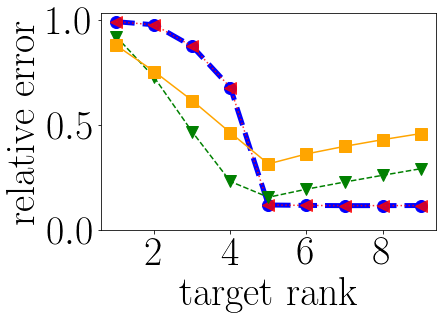

In [15]:
fontsize = 50
markersize = 12
colors = ['blue', 'green', 'orange','red','yellow']

plt.plot(rank_list, norm_errors_general_rank, 'bo', linestyle='dashed', markersize=markersize, color=colors[0],linewidth=5, label=r"\textsc{TenIPS}")
plt.plot(rank_list, norm_errors_general_paper1_rank, 'bo', marker='<', linestyle='dotted', alpha=0.8, markersize=markersize, color=colors[3], label=r"\textsc{HOSVD\_w}")
plt.plot(rank_list, norm_errors_mat_square_rank, 'bo', marker='v', linestyle='--', markersize=markersize, color=colors[1], label=r"\textsc{SqUnfold}")
plt.plot(rank_list, norm_errors_mat_unfolding0_rank, 'bo', marker='s', linestyle='-', markersize=markersize, color=colors[2], label=r"\textsc{RectUnfold}")


plt.ylabel("relative error", fontsize=fontsize-10)
plt.xlabel("target rank", fontsize=fontsize-10)
xtick_pos = [2, 4, 6, 8]
ytick_pos = [0, 0.5, 1]
plt.xticks(xtick_pos, fontsize=fontsize-10)
plt.yticks(ytick_pos, fontsize=fontsize-10)

# legend = plt.legend(loc='upper center', bbox_to_anchor=(.7, -1.05), fancybox=True, shadow=False, ncol=4, fontsize=fontsize-15)

# def export_legend(legend, expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(os.path.join(fig_path, "legend_relative_error_on_target_rank.pdf"), bbox_inches=bbox)
    
# export_legend(legend)

fig_path = 'figs'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
plt.savefig(os.path.join(fig_path, "MCAR_relative_error_on_target_rank.pdf"), bbox_inches='tight')

least squares

In [ ]:
ratio = 0.1
sampled_Bs, select_idxs = uniform_sampling(ratio, B)
prop_B = np.ones(sampled_Bs.shape) * ratio
mask_B = np.ones(sampled_Bs.shape)
mask_B[np.invert(select_idxs)] = 0.0
B_rect = tl.unfold(B, mode=0)
mask_B_rect = tl.unfold(mask_B, mode=0)
prop_B_rect = tl.unfold(prop_B, mode=0)

In [ ]:
def one_bit_MC_fully_observed(M, link, tau, gamma, max_rank=None,
                              apg_max_iter=500, apg_eps=1e-12,
                              apg_use_restart=True):
    m = M.shape[0]
    n = M.shape[1]
    tau_sqrt_mn = tau * np.sqrt(m*n)

    def prox(_A, t):
        _A = _A.reshape(m, n)
        if max_rank is None:
            U, S, VT = svds(_A, k=min(_A.shape))
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)
        else:
            U, S, VT = randomized_svd(_A, max_rank)
        nuclear_norm = np.sum(S)
        if nuclear_norm > tau_sqrt_mn:
            S *= tau_sqrt_mn / nuclear_norm
            _A = np.dot(U * S, VT)
        mask = np.abs(_A) > gamma
        if mask.sum() > 0:
            _A[mask] = np.sign(_A[mask]) * gamma

        return _A.flatten()

    M_one_mask = (M == 1)
    M_zero_mask = (M == 0)
    def grad(_A):
        _A = _A.reshape(m, n)
        return (std_logistic_function(_A) - M).flatten()

    A_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True)
    P_hat = link(A_hat.reshape(m, n))
    return P_hat

In [ ]:
def weighted_softimpute(X, M, W, lmbda, max_rank=None,
                        min_value=None, max_value=None,
                        apg_max_iter=100, apg_eps=1e-6,
                        apg_use_restart=True):
    m = X.shape[0]
    n = X.shape[1]

    def prox(Z, t):
        Z = Z.reshape(m, n)

        if max_rank is None:
            U, S, VT = svds(Z, k=min(Z.shape)-1)
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)

        else:
            U, S, VT = randomized_svd(Z, max_rank)
        S = np.maximum(S - lmbda*t, 0)
        Z = np.dot(U * S, VT)

        # clip values
        if min_value is not None:
            mask = Z < min_value
            if mask.sum() > 0:
                Z[mask] = min_value
        if max_value is not None:
            mask = Z > max_value
            if mask.sum() > 0:
                Z[mask] = max_value

        return Z.flatten()

    M_one_mask = (M == 1)
    masked_weights = W[M_one_mask]
    masked_X = X[M_one_mask]
    def grad(Z):
        grad = np.zeros((m, n))
        grad[M_one_mask] = (Z.reshape(m, n)[M_one_mask] - masked_X) * masked_weights
        return grad.flatten()

    X_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True).reshape((m, n))
    return X_hat


In [ ]:
start = time.time()
B_rect_hat_lstsq = weighted_softimpute(B_rect, mask_B_rect, prop_B_rect, lmbda=.0001)
elapsed_lstsq = time.time() - start

In [ ]:
normalized_error(B_rect_hat_lstsq, B_rect)

In [ ]:
elapsed_lstsq